In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import auc
path = os.getcwd() + '/'
from tables import open_file
from scipy.interpolate import CubicSpline
from scipy.integrate import quad, simps

In [2]:
def B_spline(x, k, i, t):
    """
    B-spline
    t : numpy array
      knots
    k, i : int
      spline number
    return: B_ki spline at point x
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B_spline(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B_spline(x, k-1, i+1, t)
    return c1 + c2

def distribution(x, x_knots, b):
    """
    proton distribution
    x_knots : numpy array
    b : numpy array
      weights
    return: time at point x
    """
    t = x_knots
    T = 1e-19
    for i in range(1, len(t)-5):
        T += b[i-1]*B_spline(x, 3, i, t)
    return T

In [3]:
resukt = []
energies = []
with open_file(path + 'result_detail.hdf5') as h5file:
    for group in h5file.root:
        table = h5file.get_node(group, "deposit")
        energy = table.attrs["values_macros_energy"]
        number = table.attrs["values_macros_number"]
        data = table.read()
        data = data["event"].sum(axis=0) / number
        resukt.append(data)
        energies.append(energy)
data = np.array(resukt) #сразу разбиты на 20 шайб
energies = np.array(energies) #энергии протонов, от 60 до 80 МэВ с шагом 0.05 МэВ

In [4]:
weights = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.85477563, 0.88621047, 0.        , 0.        , 0.08724451,
       0.        , 0.        , 0.        , 0.        , 0.02408928])

errors = np.array([0.52456698, 0.75110384, 0.79366747, 0.94208268, 0.77658627,
       0.83759377, 0.95626912, 1.        , 1.        , 0.43076316])

weights = np.array([0.02097887, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.98153884, 0.        ,
        0.00164911, 0.03977522, 0.04088125, 0.04648619, 0.0132813 ,
        0.        , 0.        , 0.        , 0.        , 0.02442026]) # 20 first step
errors = np.array([0.53867167, 0.73379509, 0.79765245, 0.96731091, 0.80156418,
        0.8956091 , 1.        , 1.        , 1.        , 0.1       ])

In [5]:
a0 =  energies[147]# 67.4 MeV - minimum possible proton energy
a1 = energies[225] #71.3 maximum possible proton energy
n = 15 #number of splines
x_knots = np.concatenate([np.linspace(a0-0.3, a0-0.1, 3), np.linspace(a0, a1, n), np.linspace(a1 + 0.1, a1 + 0.3, 3)])

In [6]:
proton_bunch = np.array([distribution(x, x_knots, weights) for x in energies])
proton_bunch = proton_bunch/np.sum(proton_bunch)

In [7]:
data_prob = np.zeros(data.shape)
for i in range(data.shape[0]):
    data_prob[i] = data[i]*proton_bunch[i]

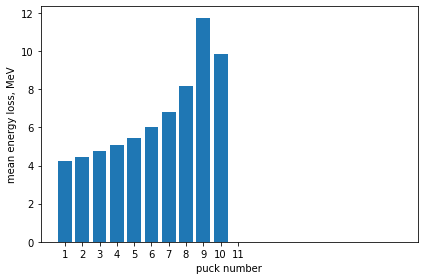

In [8]:
data_mean = np.sum(data_prob, axis=0)
plt.bar(range(1, 21), data_mean)
plt.xticks(range(1, 12))
plt.ylabel("mean energy loss, MeV")
plt.xlabel('puck number')
plt.tight_layout()
#plt.savefig('small_unification_plots/losses_mean.png', dpi=300, transparent=True)

In [9]:
mean_error=np.loadtxt('popts_small.txt') #mean and error of gaussian for each puck

In [10]:
calibr = data_mean[:10]/mean_error.T[0]

In [11]:
np.savetxt('calibration_from_min_max_spectrum_splines_20_step1.txt', calibr)

In [46]:
np.loadtxt('calibration_from_min_max_lower.txt'), np.loadtxt('calibration_from_min_max_spectrum_splines_15.txt')

(array([0.00036967, 0.00056936, 0.0005457 , 0.00053688, 0.00044349,
        0.00043924, 0.00059634, 0.00049756, 0.00056417, 0.00052089]),
 array([0.00037158, 0.00057027, 0.00054863, 0.00053969, 0.00044753,
        0.00044366, 0.00060299, 0.00050283, 0.00057221, 0.0004558 ]))

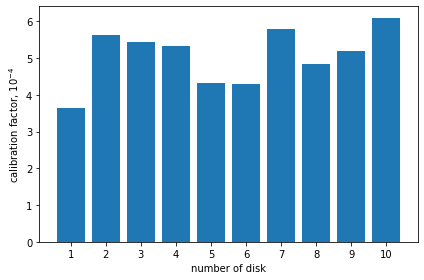

In [12]:
plt.bar(range(1, 11), calibr*10**4)
plt.xticks(range(1, 11))
plt.ylabel(r"calibration factor, $10^{-4}$")
plt.xlabel('number of disk')
plt.tight_layout()
#plt.savefig('small_unification_plots/calibr_splines_15.png', dpi=300, transparent=True)

In [145]:
np.max(calibr)/np.min(calibr), calibr, np.var(calibr), np.mean(calibr), np.mean(calibr)/np.max(calibr), np.mean(calibr)/np.min(calibr)

(1.6250187591120557,
 array([0.00037165, 0.0005699 , 0.00054713, 0.00053878, 0.00044731,
        0.00044347, 0.00060394, 0.00050429, 0.00057602, 0.00045041]),
 4.9838819890834855e-09,
 0.0005052897938152826,
 0.8366503216215052,
 1.3595724674520806)

In [39]:
calibr = np.loadtxt('calibration_from_min_max_lower.txt')

In [40]:
data_experiment = np.load('processed_data_7pucks.npy')
n = len(data_experiment.T[:][:])
data_calibrated = np.zeros((n, 10))
for i in range(n):
    data_calibrated[i] = data_experiment.T[:][i]*calibr

In [41]:
experiment_peaks_position=np.zeros(len(data_calibrated))
for i in range(len(data_calibrated)):
    event = data_calibrated[i]
    experiment_peaks_position[i] = np.argmax(event) + 1
    
hist, bins = np.histogram(experiment_peaks_position, bins=range(1, 12), density=True)
bins = np.delete(bins, -1)

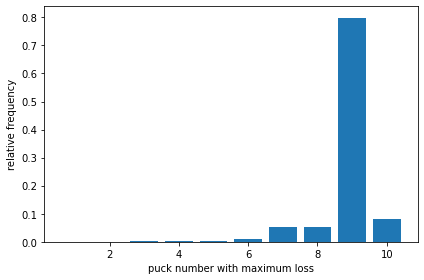

In [43]:
plt.bar(bins, hist)
plt.ylabel('relative frequency')
plt.xlabel('puck number with maximum loss')
plt.tight_layout()
#plt.savefig('small_unification_plots/bar_energy_calibr_min_max.png', dpi=300, transparent=True)

In [29]:
resukt = []
energies = []
with open_file(path + 'result_detail.hdf5') as h5file:
    for group in h5file.root:
        table = h5file.get_node(group, "deposit")
        energy = table.attrs["values_macros_energy"]
        number = table.attrs["values_macros_number"]
        data = table.read()
        data = data["event"]#.sum(axis=0) / number
        resukt.append(data)
        energies.append(energy)
data = np.array(resukt) #сразу разбиты на 20 шайб
energies = np.array(energies) #энергии протонов, от 60 до 80 МэВ с шагом 0.05 МэВ

In [35]:
histogram = np.zeros(10)
for number in range(170, 175+1):
    peaks_position = np.zeros(len(data[number])) #позиция пика 
    for i, event in enumerate(data[number]):
        peaks_position[i] = np.argmax(event) + 1

    hist, bins = np.histogram(peaks_position, bins=range(1, 12))
    bins = np.delete(bins, -1)
    histogram = histogram + hist

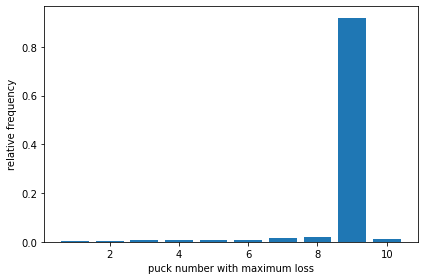

In [37]:
plt.bar(bins, histogram/sum(histogram))
plt.ylabel('relative frequency')
plt.xlabel('puck number with maximum loss')
plt.tight_layout()
#plt.savefig('small_unification_plots/bar_energy_sum.png', dpi=300, transparent=True)